In [ ]:
def get_operator_info(operator):

    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias:', op_spi.getOperatorDescriptor().getAlias()) 
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
          print(param.getName(), "or", param.getAlias())

In [ ]:
get_operator_info("Subset")

In [ ]:
# Instalando snappy no colab
import os                                   
import google.colab                                                      
import sys

google.colab.drive.mount('/content/drive')

with google.colab.output.use_tags('snappy'):
    sys.stdout.flush()
    !pip install -q condacolab &> /dev/null
    import condacolab
    condacolab.install_miniconda()
    sys.stdout.write('\nInstalando snappy\n')
    sys.stdout.flush()
    !conda install -c terradue -c conda-forge snap=8.0.0 &> /dev/null
google.colab.output.clear(output_tags='snappy')

# Update
with google.colab.output.use_tags('initialization'):
    sys.stdout.flush()
google.colab.output.clear(output_tags='initialization')

In [ ]:
# Bibliotecas
import numpy as np
import snappy
from snappy import GPF
from snappy import ProductIO
from snappy import HashMap
from snappy import jpy
from snappy import ProductUtils
import subprocess
import matplotlib.pyplot as plt
import h5py

In [ ]:
# Acessando os operadores Java
HashMap = jpy.get_type('java.util.HashMap')
parameters = HashMap()

# Função para ler arquivo
def read(file):
    return ProductIO.readProduct(file)

# Função para escrever arquivo em disco
def write(product, file):
    return ProductIO.writeProduct(product, file, "HDF5")

In [ ]:
# Orbit files
def apply_orbit_file(product):   
    parameters.put("Orbit State Vectors", "Sentinel Precise (Auto Download)")
    parameters.put("Polynomial Degree", 3)    
    return GPF.createProduct("Apply-Orbit-File", parameters, product)

# Thermal Noise removal
def thermal_noise(product):      
    parameters.put('removeThermalNoise', True)
    return GPF.createProduct("ThermalNoiseRemoval", parameters,product)

# Calibration
def calibration(product):
    parameters.put('outputSigmaBand ', True)
    return GPF.createProduct("Calibration", parameters,product)

# Terrain correction
def terrain_corr(product):  
    parameters.put('Digital Elevation Model', 'SRTM 1Sec HGT (Auto Download)')
    parameters.put("DEM Resampling Method", "BICUBIC_INTERPOLATION")
    parameters.put("Image Resampling Method", "BICUBIC_INTERPOLATION")
    parameters.put('pixelSpacingInMeter', 10.0) 
    parameters.put('saveSelectedSourceBand', True)
    return GPF.createProduct("Terrain-Correction", parameters,product)

In [ ]:
# Fluxo de processos
def workflow(file):

    print('Read file...')
    product_1 = read(file)

    print('Orbit files...')
    product_orbitFile_1 = apply_orbit_file(product_1)
    

    print('Remove thermal noise...')
    thermal = thermal_noise(product_orbitFile_1)

    print('Calibration...')
    cal = calibration(thermal)
    
    print('Terrain Correction...')
    corr = terrain_corr(cal)

    print('Save...')  
    write(corr, "result")
  

In [ ]:
# Imagem a ser processada
s1 = 'S1A_IW_GRDH_1SDV_20220311T084530_20220311T084555_042271_0509D6_BDA7.zip'

In [ ]:
# Rodando fluxo de processamento
workflow(s1)

Read file...
Orbit files...
Remove thermal noise...
Calibration...
Terrain Correction...
Save...


In [ ]:
# Lendo resultado
f = h5py.File("/content/result.h5")

In [ ]:
# Acessando bandas
data = f['bands']

In [ ]:
# Armazenando polarização VH
vh = data['Sigma0_VH']

In [ ]:
# Convertendo para numpy array
vh = np.array(vh)

In [ ]:
# Função para expansão do histograma
def expansao(img, percent_ini, percent_fim):
    s = np.zeros_like(img)
    x,y = 0,255  
    w = np.percentile(img, percent_ini)
    z = np.percentile(img, percent_fim)        
    p = x + (img - w) * (y - x) / (z - w)    
    p[p<x] = x
    p[p>y] = y
    s = p
    return s

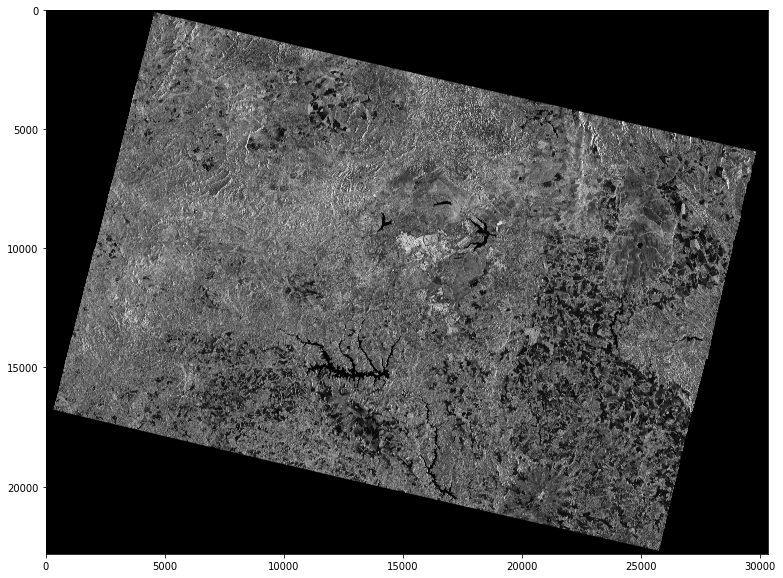

In [ ]:
# Visualizando resultado
plt.imshow(expansao(vh,2,98), cmap='gray')